In [1]:
%cd /home/kong/simple_detection_dogcat/tmp/yolov5/

/home/kong/simple_detection_dogcat/tmp/yolov5


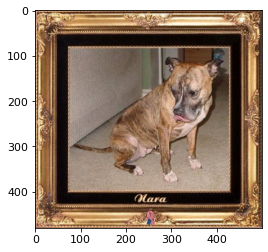

In [86]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import pickle
im = cv2.imread("/home/kong/simple_detection_dogcat/dataset/image/dog.98.jpg")
im = cv2.cvtColor(im, cv2.COLOR_RGB2BGR)
plt.imshow(im)

In [4]:
from fastapi.middleware.cors import CORSMiddleware
from fastapi import FastAPI, File, Body, UploadFile, Request
from typing import Optional
from pydantic import BaseModel
from starlette.responses import JSONResponse
import uvicorn
from uvicorn.config import LOGGING_CONFIG
from PIL import Image, ImageDraw, ImageFont
import io
import matplotlib.pyplot as plt

# import the needed libraries
import argparse
import os
import platform
import shutil
import time
from pathlib import Path

import cv2
import torch
import torch.backends.cudnn as cudnn
import numpy as np
from numpy import random

from models.experimental import attempt_load
from utils.datasets import LoadStreams, LoadImages, letterbox
from utils.general import check_img_size, check_requirements, check_imshow, non_max_suppression, apply_classifier, \
    scale_coords, xyxy2xywh, strip_optimizer, set_logging, increment_path
# from utils.plots import plot_one_box_PIL
from utils.torch_utils import select_device, time_sync

import base64
import json
import requests

In [122]:
class Opt():
    def __init__(self,project="",
                 img_size=256,
                 conf_thres=0.5,
                 iou_thres=0.5,
                 weights='/home/kong/simple_detection_dogcat/tmp/yolov5/runs/train/exp/weights/best.pt',
                 device='0',
                 classes=None,
                 agnostic_nms=False,
                 augment=False):
        self.project = project
        self.weights = weights
        self.img_size = img_size
        self.conf_thres = conf_thres
        self.iou_thres = iou_thres
        self.device = device
        self.classes = classes
        self.agnostic_nms = agnostic_nms
        self.augment = augment
#         self.server_port = server_port
    

In [123]:
opt = Opt()

In [124]:
import random
def randRgb(): 
    return(random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
randRgb()

(96, 184, 198)

In [125]:
colors = [[random.randint(0, 255) for _ in range(3)] for _ in range(len(names))]
tuple(colors)

([14, 38, 222], [54, 8, 16])

In [126]:
colors[0]

[14, 38, 222]

In [127]:
names.index('dog')

1

In [128]:
def plot_one_box_PIL(box, img, color=None, label=None, line_thickness=None):
    # img = Image.fromarray(img)
    draw = ImageDraw.Draw(img)
    line_thickness = line_thickness or max(int(min(img.size) / 200), 2)
#     draw.rectangle(box, width=line_thickness, outline=tuple(color))  # plot
#     draw.rectangle(box, width=line_thickness, outline="red")
    draw.rectangle(box, width=line_thickness, outline=color)
    if label:
        fontsize = max(round(max(img.size) / 40), 12)
        font = ImageFont.truetype("font/arial.ttf", fontsize)
        txt_width, txt_height = font.getsize(label)
#         draw.rectangle([box[0], box[1] - txt_height + 4, box[0] + txt_width, box[1]], fill='red')
        draw.rectangle([box[0], box[1] - txt_height + 4, box[0] + txt_width, box[1]], fill=color)
        draw.text((box[0], box[1] - txt_height + 1), label, font=font)
        draw.text(((box[0], box[1] - txt_height + 1)), label,fill='white', font = font)
    return np.asarray(img)

def draw_image(frame, pred, names, img, colors):
    width, height = frame.size
    newsize = (height, width)

    result = []
    for i, det in enumerate(pred):  # detections per image
        gn = torch.tensor(newsize)[[1, 0, 1, 0]]  # normalization gain whwh
        if det is not None and len(det):
            # Rescale boxes from img_size to im0 size
            det[:, :4] = scale_coords(img.shape[2:], det[:, :4], newsize).round()

            # Write results
            for *xyxy, conf, cls in det:
                score = float('%.8f' % (conf)) *100
                result.append({
                    "class_name": names[int(cls)],
                    "confidence": score,
                    "position": {
                        "xmin": int(xyxy[0]),
                        "ymin": int(xyxy[1]),
                        "xmax": int(xyxy[2]),
                        "ymax": int(xyxy[3])
                    }
                })
                label = f'{names[int(cls)]} {score:.2f}%'
                plot_one_box_PIL(xyxy, frame, label=label, color=colors[int(cls)], line_thickness=5)
    return frame, result
def preprocess_image(frame):

    frame = np.array(frame)

    # Padded resize
    img = letterbox(frame, new_shape=imgsz)[0]
    if len(img.shape) < 3:
        img = np.stack((img,)*3, axis=-1)

    # Convert
    img = img[:, :, ::-1].transpose(2, 0, 1)  # BGR to RGB, to 3x416x416
    img = np.ascontiguousarray(img)
    img = torch.from_numpy(img).to(device)
    img = img.half() if half else img.float()  # uint8 to fp16/32
    img /= 255.0  # 0 - 255 to 0.0 - 1.0
    if img.ndimension() == 3:
        img = img.unsqueeze(0)
    return img

In [129]:
weights, imgsz = opt.weights, opt.img_size
device = select_device(opt.device)
half = device.type != 'cpu'  # half precision only supported on CUDA
model = attempt_load(weights, map_location=device)  # load FP32 model
imgsz = check_img_size(imgsz, s=model.stride.max())  # check img_size
if half:
    model.half()  # to FP16
names = model.module.names if hasattr(model, 'module') else model.names
colors = [[random.randint(0, 255) for _ in range(3)] for _ in range(len(names))]
colors = ["red","green"]
img = torch.zeros((1, 3, imgsz, imgsz), device=device)  # init img
_ = model(img.half() if half else img) if device.type != 'cpu' else None  # run once

YOLOv5 🚀 v6.0-253-ga45e472 torch 1.8.1+cu102 CUDA:0 (Tesla V100-PCIE-32GB, 32510MiB)

Fusing layers... 
Model Summary: 213 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs


[{'class_name': 'dog', 'confidence': 89.599609, 'position': {'xmin': 46, 'ymin': 40, 'xmax': 555, 'ymax': 600}}]


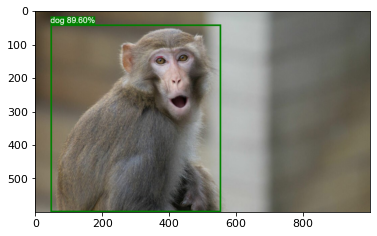

In [137]:
# data_image = Image.open("/home/kong/covid-19_2022/dataset/test1/COVID-303.png")
test_path = '/home/kong/simple_detection_dogcat/tmp/cat_dog/images/test/'
data_image = Image.open(test_path+'cat.3941.jpg')
data_image = Image.open("/home/kong/simple_detection_dogcat/dataset/16972254027_ca7439993f_k-e1629196852921-1000x600.jpg")
data_image = data_image.convert('RGB')
width, height = data_image.size
if width > 3800 or height > 3800:
    data_image.resize((int(width/3), int(height/3)))

elif width > 2500 or height > 2500:
    data_image.resize((int(width/2.5), int(height/2.5)))
    
img = preprocess_image(data_image)

pred = model(img, augment=opt.augment)[0]
pred = non_max_suppression(pred, opt.conf_thres, opt.iou_thres, classes=opt.classes, agnostic=opt.agnostic_nms)
img_result, result = draw_image(data_image, pred, names, img, colors)
print(result)
plt.imshow(img_result)

In [136]:
result

[{'class_name': 'dog',
  'confidence': 95.214844,
  'position': {'xmin': 77, 'ymin': 45, 'xmax': 756, 'ymax': 605}}]